# Classifying fake news using supervised learning with NLP

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier

In [2]:
# Read the data
df = pd.read_csv("news.csv")

In [3]:
df.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [4]:
# drop Unnamed: 0
df = df.drop(['Unnamed: 0'], axis=1)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6335 entries, 0 to 6334
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   6335 non-null   object
 1   text    6335 non-null   object
 2   label   6335 non-null   object
dtypes: object(3)
memory usage: 148.6+ KB


In [6]:
df.shape

(6335, 3)

## Dataset Description

This dataset contains news articles along with their titles, content, and corresponding labels. The data is structured in a CSV file with three columns:

- **title**: Represents the titles of the news articles.
- **text**: Contains the content or main body of the articles.
- **label**: Indicates the category or authenticity label of the news articles.

The dataset consists of 6335 entries and is intended for use in the task of fake news detection.

In [7]:
# Get the labels
df['label'].value_counts()

label
REAL    3171
FAKE    3164
Name: count, dtype: int64

/home/codespace/.python/current/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/codespace/.python/current/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


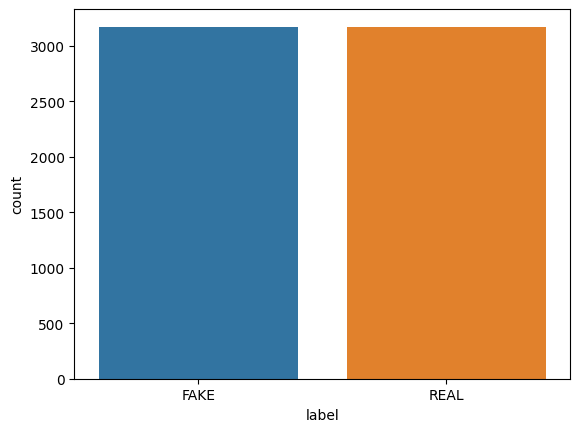

In [8]:
# Convert 'label' to categorical data
df['label'] = df['label'].astype('category')

# Plot the count plot
sns.countplot(data=df, x='label')
plt.show()

This indicates that the dataset is relatively balanced between real and fake news articles, which is good for training a machine learning model for fake news detection.

In [9]:
# check for missing values
df.isnull().sum()

title    0
text     0
label    0
dtype: int64

In [10]:
# split the dataset into training and testing datasets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.2, random_state=42)

In [11]:
# Initialize a CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer
count_vectorizer = CountVectorizer(stop_words='english')

In [12]:
# Fit and transform the training data
count_train = count_vectorizer.fit_transform(X_train)

# Transform the test set
count_test = count_vectorizer.transform(X_test)

In [13]:
# Initialize a TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7)

In [14]:
# Transform the training data using the TF-IDF vectorizer
tfidf_train = tfidf_vectorizer.fit_transform(X_train)

# Transform the testing data using the same vectorizer
tfidf_test = tfidf_vectorizer.transform(X_test)

## Training and testing the "fake news" model with CountVectorizer

In [15]:
# Build a Multinomial Naive Bayes classifier
from sklearn.naive_bayes import MultinomialNB
nb_classifier = MultinomialNB()

# Fit the classifier to the training data
nb_classifier.fit(count_train, y_train)

# Create the predicted tags
pred = nb_classifier.predict(count_test)

In [16]:
# Calculate the accuracy score
from sklearn.metrics import accuracy_score, confusion_matrix
score = accuracy_score(y_test, pred)
print(score)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
print(cm)

0.898973954222573
[[544  84]
 [ 44 595]]


In [17]:
# recall, precision, f1-score, roc_auc_score, roc_curve
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

        FAKE       0.93      0.87      0.89       628
        REAL       0.88      0.93      0.90       639

    accuracy                           0.90      1267
   macro avg       0.90      0.90      0.90      1267
weighted avg       0.90      0.90      0.90      1267



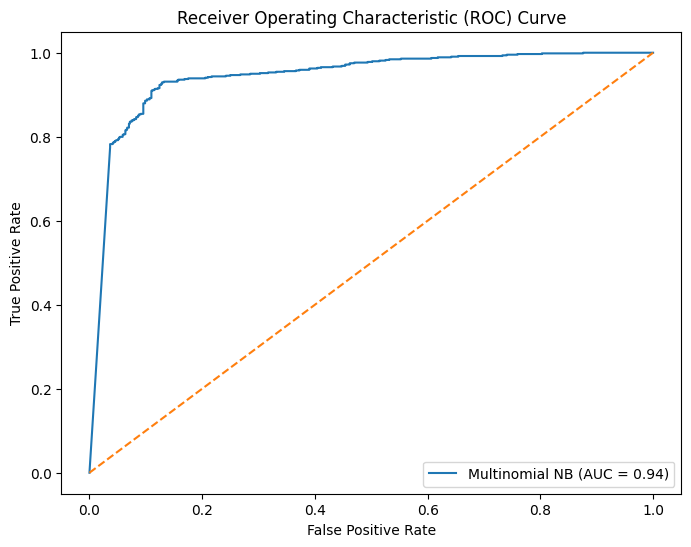

In [18]:
from sklearn.preprocessing import LabelEncoder

# Convert labels to binary values
le = LabelEncoder()
y_test_binary = le.fit_transform(y_test)

# Calculate the probabilities for positive class (REAL)
probs = nb_classifier.predict_proba(count_test)[:, 1]

# Compute ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(y_test_binary, probs)
auc = roc_auc_score(y_test_binary, probs)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Multinomial NB (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [19]:
# Build a passive-aggressive classifier with count vectorizer 
from sklearn.linear_model import PassiveAggressiveClassifier
pac = PassiveAggressiveClassifier(max_iter=50)

# Fit the classifier to the training data
pac.fit(count_train, y_train)

# Create the predicted tags
pred = pac.predict(count_test)

# Calculate the accuracy score
score = accuracy_score(y_test, pred)
print(score)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
print(cm)

0.9068666140489345
[[560  68]
 [ 50 589]]


In [20]:
# recall, precision, f1-score, roc_auc_score, roc_curve
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

        FAKE       0.92      0.89      0.90       628
        REAL       0.90      0.92      0.91       639

    accuracy                           0.91      1267
   macro avg       0.91      0.91      0.91      1267
weighted avg       0.91      0.91      0.91      1267



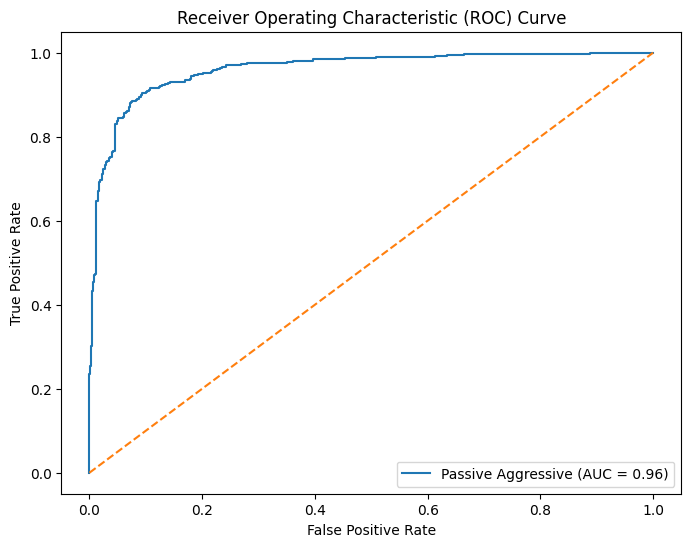

In [21]:
# For PassiveAggressiveClassifier
pac.fit(count_train, y_train)
y_scores = pac.decision_function(count_test)

fpr, tpr, thresholds = roc_curve(y_test_binary, y_scores)

# Calculate AUC
auc = roc_auc_score(y_test_binary, y_scores)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Passive Aggressive (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


## Training and testing the "fake news" model with TfidfVectorizer

In [22]:
# Build a Multinomial Naive Bayes classifier
nb_classifier = MultinomialNB()

# Fit the classifier to the training data
nb_classifier.fit(tfidf_train, y_train)

# Create the predicted tags
pred = nb_classifier.predict(tfidf_test)

# Calculate the accuracy score
score = accuracy_score(y_test, pred)
print(score)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
print(cm)

0.8453038674033149
[[443 185]
 [ 11 628]]


              precision    recall  f1-score   support

        FAKE       0.98      0.71      0.82       628
        REAL       0.77      0.98      0.87       639

    accuracy                           0.85      1267
   macro avg       0.87      0.84      0.84      1267
weighted avg       0.87      0.85      0.84      1267



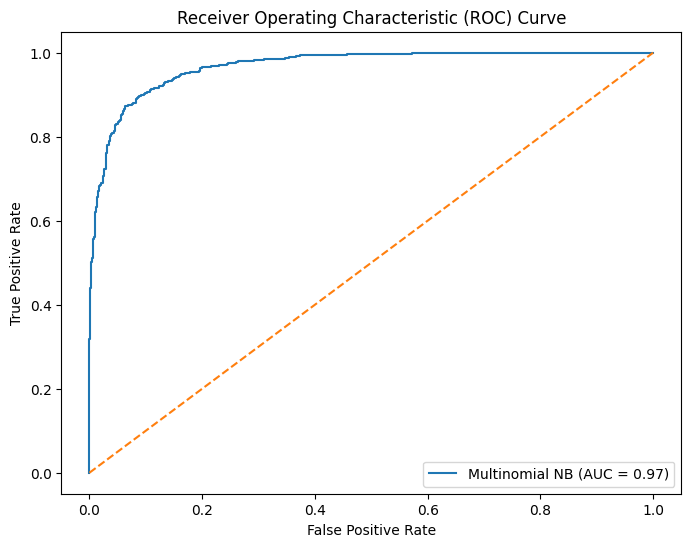

In [23]:
# recall, precision, f1-score, roc_auc_score, roc_curve
print(classification_report(y_test, pred))

# Convert labels to binary values
le = LabelEncoder()
y_test_binary = le.fit_transform(y_test)

# Calculate the probabilities for positive class (REAL)
probs = nb_classifier.predict_proba(tfidf_test)[:, 1]

# Compute ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(y_test_binary, probs)
auc = roc_auc_score(y_test_binary, probs)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Multinomial NB (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [24]:
# Build a Passive Aggressive Classifier with tfidf
pa_classifier = PassiveAggressiveClassifier(max_iter=50)

# Fit the classifier to the training data
pa_classifier.fit(tfidf_train, y_train)

# Create the predicted tags
pred = pa_classifier.predict(tfidf_test)

# Calculate the accuracy score
score = accuracy_score(y_test, pred)
print(score)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
print(cm)

0.9352801894238358
[[589  39]
 [ 43 596]]


              precision    recall  f1-score   support

        FAKE       0.93      0.94      0.93       628
        REAL       0.94      0.93      0.94       639

    accuracy                           0.94      1267
   macro avg       0.94      0.94      0.94      1267
weighted avg       0.94      0.94      0.94      1267



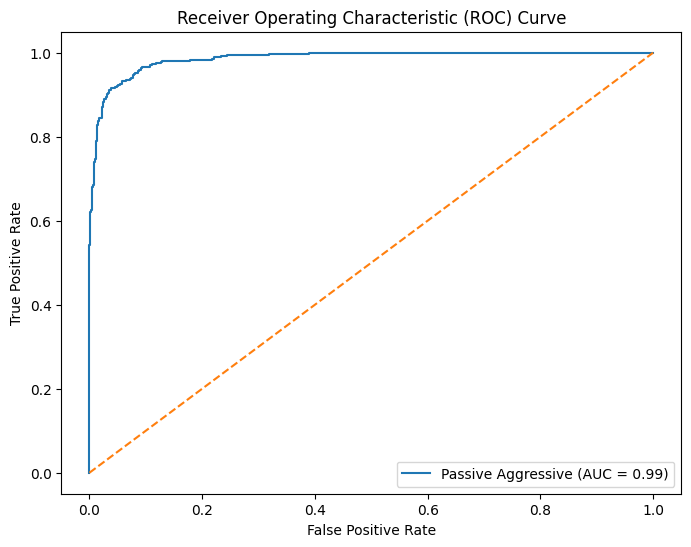

In [25]:
# recall, precision, f1-score, roc_auc_score, roc_curve
print(classification_report(y_test, pred))

# For PassiveAggressiveClassifier
pa_classifier.fit(tfidf_train, y_train)
y_scores = pa_classifier.decision_function(tfidf_test)

fpr, tpr, thresholds = roc_curve(y_test_binary, y_scores)

# Calculate AUC
auc = roc_auc_score(y_test_binary, y_scores)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Passive Aggressive (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

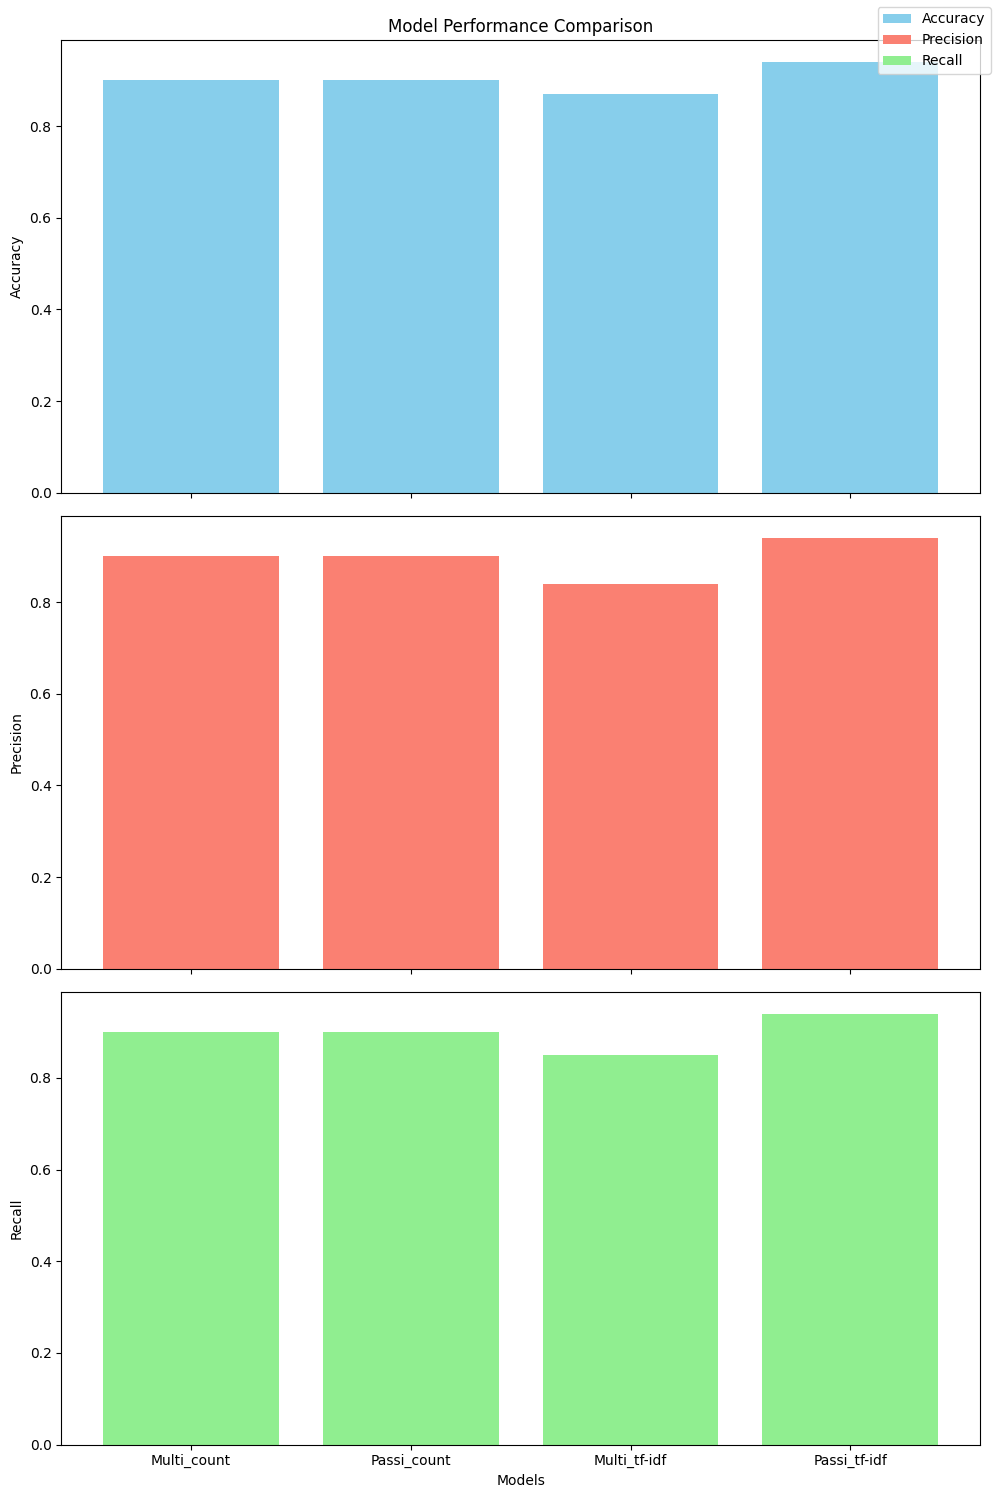

In [35]:
import matplotlib.pyplot as plt

# Define the models and their respective metrics
models = ['Multi_count', 'Passi_count', 'Multi_tf-idf', 'Passi_tf-idf']
accuracy = [0.90, 0.90, 0.87, 0.94]  # Replace with actual accuracy scores
precision = [0.90, 0.90, 0.84, 0.94] # Replace with actual precision scores
recall = [0.90, 0.90, 0.85, 0.94] # Replace with actual recall scores

# Set up positions for the bars
x = range(len(models))

# Create the bar plots
fig, axs = plt.subplots(3, 1, figsize=(10, 15), sharex=True)

# Plot accuracy
axs[0].bar(x, accuracy, label='Accuracy', color='skyblue')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Model Performance Comparison')
axs[0].set_xticks(x)
axs[0].set_xticklabels(models)

# Plot precision
axs[1].bar(x, precision, label='Precision', color='salmon')
axs[1].set_ylabel('Precision')
axs[1].set_xticks(x)
axs[1].set_xticklabels(models)

# Plot recall
axs[2].bar(x, recall, label='Recall', color='lightgreen')
axs[2].set_ylabel('Recall')
axs[2].set_xlabel('Models')
axs[2].set_xticks(x)
axs[2].set_xticklabels(models)

# Add legend
fig.legend(['Accuracy', 'Precision', 'Recall'], loc='upper right')

# Show the plots
plt.tight_layout()
plt.show()


## Some improvement:

- Use Deep Learning Models: Deep learning models have shown to be effective in fake news detection. ConvNet-RNN hybrid models and Siamese LSTMs are two examples of architectures that have been successful in this task. we can experiment with these architectures on your dataset.
- Ensemble Models: Combining different models can often lead to performance gains. we can train different models on your data and then combine their predictions to make a final decision. This ensemble method can often capture different aspects of the data and give better results.